## IMPORT LIBARRIES

In [2]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
from tqdm import tqdm

import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import matplotlib.pyplot as plt

import os
import random
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
l5kit.__version__

'1.1.0'

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

## SET CONFIG PARAMS 

In [152]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'data_path': "lyft-motion-prediction-autonomous-vehicles/",
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "model_resnet34_output",
        'lr': 1e-3,
        'weight_path': "submissions/Baseline_Resnet34/model_multi_update_lyft_public_resnet34.pth",
        'train': False,
        'predict': True
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
    'sample_data_loader': {
        'key': 'scenes/sample.zarr',
        'batch_size': 1,
        'shuffle': True,
        'num_workers': 4
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 4
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 1,
        'shuffle': False,
        'num_workers': 4
    },

    'train_params': {
        'max_num_steps': 101,
        'checkpoint_every_n_steps': 20,
    }
}

In [153]:
# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

## DATASET AND DATALOADER

In [154]:
rasterizer = build_rasterizer(cfg, dm)
sample_cfg = cfg['sample_data_loader']
sample_zarr = ChunkedDataset(dm.require(sample_cfg["key"])).open()
sample_AgentDataset = AgentDataset(cfg, sample_zarr, rasterizer)
sample_dataloader = DataLoader(sample_AgentDataset,shuffle=sample_cfg["shuffle"],batch_size=sample_cfg["batch_size"],
                             num_workers=sample_cfg["num_workers"])

print(sample_AgentDataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [155]:
print('Dataset length is ', len(sample_AgentDataset))
print('Dataloader length is ', len(sample_dataloader))

Dataset length is  111634
Dataloader length is  111634


## LOSS FUNCTION

In [156]:
# --- Function utils ---
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
import numpy as np

import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

## MODEL

In [157]:
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        #backbone = eval(architecture)(pretrained=True, progress=True)
        backbone = eval(architecture)(pretrained=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [158]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds, confidences

In [159]:
def plot_2d_points(points2D, ax=None, label=None):
    if ax == None:
        ax = plt.gca()
    #print(points2D.shape)
    ax.plot(points2D[:,0], points2D[:,1], label = label)

In [191]:
def plot_multi_mode(multi_mode_prediction):
    num_modes = multi_mode_prediction.shape[0]
    for mode in range(num_modes):
        plot_2d_points(multi_mode_prediction[mode], label=str(mode) + 'th mode')

## LOADING MODEL WEIGHTS

In [160]:
# ==== INIT MODEL=================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LyftMultiModel(cfg)

#load weight if there is a pretrained model
weight_path = cfg["model_params"]["weight_path"]
if weight_path:
    model.load_state_dict(torch.load(weight_path))
    print('Model weights loaded')

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])
print(f'device {device}')

Model weights loaded
device cuda:0


In [298]:
sample_it = iter(sample_dataloader)

In [299]:
data = next(sample_it)
_, preds, confidences = forward(data, model, device)
#print(preds.shape, confidences.shape)

In [300]:
preds = preds.cpu().detach().numpy()
world_from_agents = data["world_from_agent"].numpy()
centroids = data["centroid"].numpy()
confidences = confidences.cpu().detach().numpy()

#print(preds.shape, confidences.shape, centroids.shape)
#print(confidences)
preds = preds[0]
print(preds.shape)

(3, 50, 2)


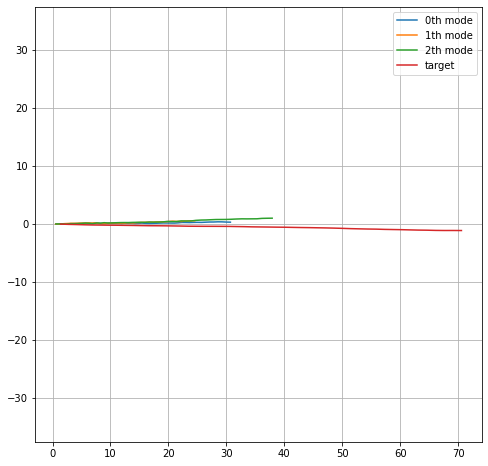

In [301]:
#fig, ax = plt.subplots(figsize = (12,12))
#plt.set_aspect('equal', 'box')
#ax.set_xlim([-5, 20])
#ax.set_ylim([-5, 5])

plt.figure(figsize = (8,8))
plt.grid(True)
plt.axis('equal')
plot_multi_mode(preds)
plot_2d_points(data['target_positions'].numpy()[0], label = 'target')
plt.legend()

In [282]:
data.keys()

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])